Attitude and Position Integration: https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-coning

In [2]:
import pandas as pd
import numpy as np
from math import sin, cos, pi, atan2, asin
import matplotlib.pyplot as plt
from statistics import mean
from scipy import integrate

from get_YPR_matrix import convert_YPR_fixed_frame

In [3]:
def readCSV(filename):
    with open(filename) as csvDataFile:
        # Read file as csv
        df = pd.read_csv(csvDataFile)
    return df


def nasa_pres(P, P0=101.29, T0=288.08):
    T = T0*((P / P0)**(1 / 5.256)) - 273.1
    h = (T-15.04)/(-0.00649)
    return h


################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp', 'Pres',
  'dTheta X', 'dTheta Y', 'dTheta Z',
  'dVel X', 'dVel Y', 'dVel Z',
  'Qtn[0]', 'Qtn[1]', 'Qtn[2]', 'Qtn[3]',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z'
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]

dvx = df['dVel X']
dvy = df['dVel Y']
dvz = df['dVel Z']

In [4]:
ax_vn = df['LinearAccelNed X']
ay_vn = df['LinearAccelNed Y']
az_vn = df['LinearAccelNed Z']*-1

vx_vn, vy_vn, vz_vn = np.zeros(len(ax_vn)),np.zeros(len(ay_vn)), np.zeros(len(az_vn))
dt = tdata[1]
x_vn, y_vn, z_vn = np.zeros(len(ax_vn)),np.zeros(len(ay_vn)), np.zeros(len(az_vn))
dt = tdata[1]

vx_vn = integrate.cumtrapz(ax_vn, tdata, initial=0) #* ft
vy_vn = integrate.cumtrapz(ay_vn, tdata, initial=0) #* ft
vz_vn = integrate.cumtrapz(az_vn, tdata, initial=0) #* ft

x_vn = integrate.cumtrapz(vx_vn, tdata, initial=0) #* ft
y_vn = integrate.cumtrapz(vy_vn, tdata, initial=0) #* ft
z_vn = integrate.cumtrapz(vz_vn, tdata, initial=0) #* ft

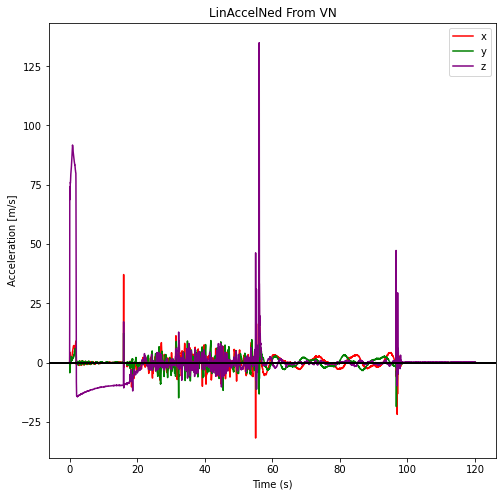

In [5]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ax_vn, color='red', label='x')
l3 = ax.plot(tdata, ay_vn, color='green', label='y')
l4 = ax.plot(tdata, az_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNed From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()

Vanilla numerical integration:
- We don't expect this to work because the IMU acceleration data is pretty biased.  When sitting on the pad the acceleration is not zero, sometimes over 1 m/s

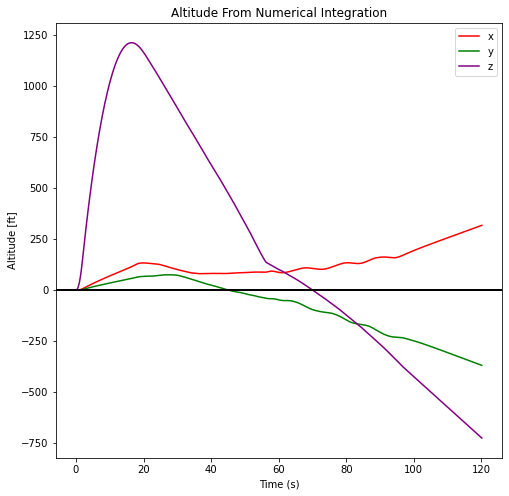

In [6]:
fig1 = plt.figure(1, figsize=(8,8))
# Just the Displacement:
ax = plt.subplot(111)
#l1 = ax.plot(tdata, altitude_NASA_pres, color='blue', label='NASA Pressure')
l2 = ax.plot(tdata, x_vn, color='red', label='x')
l3 = ax.plot(tdata, y_vn, color='green', label='y')
l4 = ax.plot(tdata, z_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Altitude From Numerical Integration")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Altitude [ft]")
ax.legend()
plt.show()

It is clear that the above is a failure.  Notice further that the magnitudes given by dv are extremely small, which accounts for the magnitude error in the above plot.  Note that this does not, by itself, account for the altitude going negative.

# Delta-Theta, Delta-Velocity
- The Delta-Theta output from the coning integral is easily combined with quaternions to produce a continuously updated attitude estimate. An updated quaternion value (qk+1) is computed from the previous quaternion value (qk+1) using Equation 1. __This equation assumes the scalar term of the quaternion is q4 and that Δθ is provided in radians.__
<br><br>
- Will Wu's code from last year says that the IMU is reading in dTheta as deg/s and dVel as m/s^2.  This might be incorrect, I don't think they used this for anything so he might've just assumed
<br><br>
- Page 76 of the VN UM says that dTheta is in deg, dTime is the time interval, and dVel is m/s

In [7]:
# dTheta [degrees (?)]
dtx = np.array(df['dTheta X'])
dty = np.array(df['dTheta Y'])
dtz = np.array(df['dTheta Z'])

dTheta = np.dstack((dtx, dty, dtz))
dTheta = np.reshape(dTheta, (dTheta.shape[2], dTheta.shape[1]))
dTheta0 = dTheta[:,0]
assert dTheta0[0]==dtx[0]
print(f"dTheta0 = {dTheta0}")

# dVelocity [m/s]
dvx = np.array(df['dVel X'])
dvy = np.array(df['dVel Y'])
dvz = np.array(df['dVel Z'])

dVel = np.dstack((dvx, dvy, dvz))
dVel = np.reshape(dVel, (dVel.shape[2], dVel.shape[1]))
dVel0 = dVel[:,0]
assert dVel0[0]==dvx[0]
print(f"dVel0 = {dVel0}")

# Quaternion
# The estimated attitude quaternion: last term is the scalar value
# The attitude is given as the body frame wrt the local North East Down (NED) frame
qx = np.array(df['Qtn[0]'])
qy = np.array(df['Qtn[1]'])
qz = np.array(df['Qtn[2]'])
qw = np.array(df['Qtn[3]'])

quat = np.dstack((qx, qy, qz, qw))
quat = np.reshape(quat, (quat.shape[2], quat.shape[1]))
quat0 = np.reshape(quat[:,0], (4,1))
print(f"quat0 = {quat0}")

dTheta0 = [ 0.00268068 -2.16498     0.0901784 ]
dVel0 = [ 0.0018463  0.0263761 -0.0705482]
quat0 = [[ 0.343931]
 [-0.333234]
 [-0.976224]
 [ 0.315376]]


Delta Theta as a function of time
> These should be LOW! The actual orientation is this but integrated, shown below

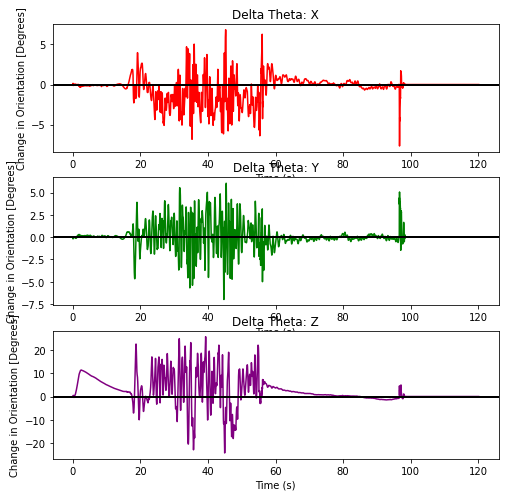

In [8]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(311)
l2 = ax.plot(tdata, dtx, color='red', label='x')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Delta Theta: X")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Change in Orientation [Degrees]")

ax = plt.subplot(312)
l3 = ax.plot(tdata, dty, color='green', label='y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Delta Theta: Y")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Change in Orientation [Degrees]")

ax = plt.subplot(313)
l4 = ax.plot(tdata, dtz, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Delta Theta: Z")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Change in Orientation [Degrees]")

plt.show()

In [9]:
def quat2ypr(quat):
    # Figure out if this returns an answer is rads or deg
    # Presumably rads
    
    q1 = quat[0][0]  # x
    q2 = quat[1][0]  # y
    q3 = quat[2][0]  # z
    q0 = quat[3][0]  # w
    
    #yaw = atan2(pi/180 * (2.*(q1*q2 + q0*q3)), pi/180 * (q0*q0 + q1*q1 - q2*q2 - q3*q3))
    #pitch = asin(pi/180 * (-2.*(q1*q3 - q0*q2)))
    #roll = atan2(pi/180 * 2.0*(q2*q3 + q0*q1), pi/180 * (q0*q0 - q1*q1 - q2*q2 + q3*q3))
    
    yaw = atan2((2.*(q1*q2 + q0*q3)), (q0*q0 + q1*q1 - q2*q2 - q3*q3))
    pitch = asin((-2.*(q1*q3 - q0*q2)))
    roll = atan2(2.*(q2*q3 + q0*q1), (q0*q0 - q1*q1 - q2*q2 + q3*q3))
    return np.array([yaw, pitch, roll])


def quat_mag(quat):
    den = ((quat[0][0])**2 + (quat[1][0])**2 +
           (quat[2][0])**2 + (quat[3][0])**2)
    return quat / np.sqrt(den)

In [10]:
# ATTITUDE INTEGRATION
qk = quat0
qkp1_hat = [0]*len(dvz)
gamma_list = [0]*len(dvz)
threshold = 10**(-5)

### RESET DTHETA SO YOU DON'T KEEP MULTIPLYING BY PI/180 ###
###############################################################
dTheta = np.dstack((dtx, dty, dtz))
dTheta = np.reshape(dTheta, (dTheta.shape[2], dTheta.shape[1]))
dTheta0 = dTheta[:,0]
assert dTheta0[0]==dtx[0]
###############################################################

dTheta *= pi/180
dTheta0 *= pi/180

for i in range(len(qkp1_hat)):
    gamma = np.linalg.norm(dTheta[:, i])/2
    gamma_list[i] = gamma

    if gamma >= threshold:
        psi = (sin(gamma)/(2*gamma)) * dTheta[:, i]
    else:
        psi = 0.5 * dTheta[:, i]

    psi1 = psi[0]
    psi2 = psi[1]
    psi3 = psi[2]
    psiX = np.array(([0, -psi3, psi2], [psi3, 0, -psi1], [-psi2, psi1, 0]))

    t1 = cos(gamma) * np.array(([1, 0, 0], [0, 1, 0], [0, 0, 1]))
    t2 = np.reshape(psi, (3,1))
    t3 = -np.reshape(psi, (1,3))
    t4 = cos(gamma)

    top = np.c_[t1, t2]
    bottom = np.reshape(np.append(t3, t4), (1, 4))

    qkp1 = np.matmul(np.vstack((top, bottom)), qk)

    qkp1_hat[i] = quat_mag(qkp1)
    qk = qkp1_hat[i]

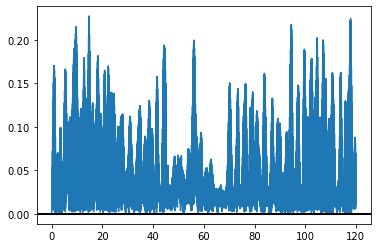

In [11]:
plt.plot(tdata, gamma_list)
l5 = plt.axhline(y=threshold, color='black', linewidth=2)
plt.show()

## I don't remember what this transition represents

In [12]:
# Body frame YPR
# byaw, bpitch, broll = [0]*len(qkp1_hat), [0]*len(qkp1_hat), [0]*len(qkp1_hat)
byaw, bpitch, broll = np.zeros(len(qkp1_hat)), np.zeros(len(qkp1_hat)), np.zeros(len(qkp1_hat))

for idx, quat in enumerate(qkp1_hat):
    bypr = quat2ypr(quat)
    byaw[idx], bpitch[idx], broll[idx] = bypr[0], bypr[1], bypr[2]

In [13]:
byaw[0:10]

array([-2.35712564, -2.37084059, -2.36069861, -2.36768572, -2.3838283 ,
       -2.36178806, -2.36895033, -2.38627965, -2.35254812, -2.36048374])

In [32]:
L = qx.shape[0]

# Calculated quaternion
qx = np.reshape(np.array([quat[0] for quat in qkp1_hat]), (L,1))
qy = np.reshape(np.array([quat[1] for quat in qkp1_hat]), (L,1))
qz = np.reshape(np.array([quat[2] for quat in qkp1_hat]), (L,1))
qw = np.reshape(np.array([quat[3] for quat in qkp1_hat]), (L,1))

# VN Measured Quaternion
qx_VN = np.reshape(np.array(df['Qtn[0]']), (L,1))
qy_VN = np.reshape(np.array(df['Qtn[1]']), (L,1))
qz_VN = np.reshape(np.array(df['Qtn[2]']), (L,1))
qw_VN = np.reshape(np.array(df['Qtn[3]']), (L,1))

# Define percent error between calculated and measured quat component
qxe = (qx - qx_VN)/qx_VN
qye = (qy - qy_VN)/qy_VN
qze = (qz - qz_VN)/qz_VN
qwe = (qw - qw_VN)/qw_VN

Quaternion Component as a function of time


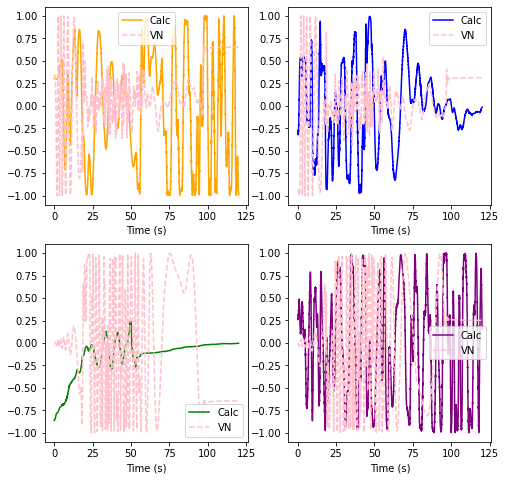

In [33]:
fig1 = plt.figure(1, figsize=(8,8))
ax1 = plt.subplot(221)
l1 = ax1.plot(tdata, qx, color='orange', label='Calc')
l1 = ax1.plot(tdata, qx_VN, color='pink', linestyle="--", label='VN')

ax2 = plt.subplot(222)
l1 = ax2.plot(tdata, qy, color='blue', label='Calc')
l1 = ax2.plot(tdata, qy_VN, color='pink', linestyle="--", label='VN')

ax3 = plt.subplot(223)
l1 = ax3.plot(tdata, qz, color='green', label='Calc')
l1 = ax3.plot(tdata, qz_VN, color='pink', linestyle="--", label='VN')

ax4 = plt.subplot(224)
l1 = ax4.plot(tdata, qw, color='purple', label='Calc')
l1 = ax4.plot(tdata, qw_VN, color='pink', linestyle="--", label='VN')

print("Quaternion Component as a function of time")
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('Time (s)')
    ax.legend()
plt.show()

Error as a function of time for each Quaternion Component


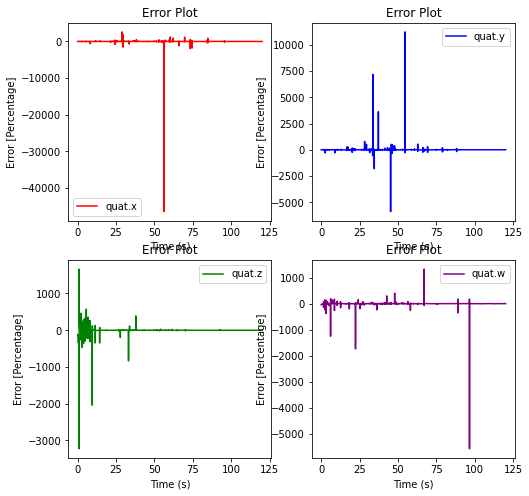

In [34]:
fig1 = plt.figure(1, figsize=(8,8))
ax1 = plt.subplot(221)
l1 = ax1.plot(tdata, qxe, color='red', label='quat.x')
ax2 = plt.subplot(222)
l2 = ax2.plot(tdata, qye, color='blue', label='quat.y')
ax3 = plt.subplot(223)
l3 = ax3.plot(tdata, qze, color='green', label='quat.z')
ax4 = plt.subplot(224)
l4 = ax4.plot(tdata, qwe, color='purple', label='quat.w')

print("Error as a function of time for each Quaternion Component")
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_title("Error Plot")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel("Error [Percentage]")
    ax.legend()
plt.show()

# YPR Analysis
- The estimated attitude Yaw, Pitch, and Roll angles measured in degrees. The attitude is given as a 3,2,1 Euler angle sequence describing the body frame with respect to the local North East Down (NED) frame. This field is equivalent to the YawPitchRoll field in group 5.

In [36]:
# Calculated YPR
# byaw, bpitch, broll = [0]*len(qkp1_hat), [0]*len(qkp1_hat), [0]*len(qkp1_hat)
byaw, bpitch, broll = np.zeros(len(qkp1_hat)), np.zeros(len(qkp1_hat)), np.zeros(len(qkp1_hat))

for idx, quat in enumerate(qkp1_hat):
    bypr = quat2ypr(quat)
    byaw[idx], bpitch[idx], broll[idx] = bypr[0], bypr[1], bypr[2]

# VN YPR
YPR_fields = ['Roll', 'Pitch','Yaw',]
YPR_df = pd.read_csv(datafile, skipinitialspace=True, usecols=YPR_fields)
roll = YPR_df['Roll']
pitch = YPR_df['Pitch']
yaw = YPR_df['Yaw']

# VN Quat YPR
VN_quat = np.array([[qx_VN],[qy_VN],[qz_VN],[qw_VN]])
VN_quat = np.reshape(VN_quat, (4,L))
vnyaw, vnpitch, vnroll = [0]*VN_quat.shape[1], [0]*VN_quat.shape[1], [0]*VN_quat.shape[1]
for idx in range(VN_quat.shape[1]):
    quat = VN_quat[:,idx]
    quat = np.reshape(quat, (len(quat),1))
    vnypr = quat2ypr(quat)
    vnyaw[idx], vnpitch[idx], vnroll[idx] = vnypr[0], vnypr[1], vnypr[2]

Comparing each angular component


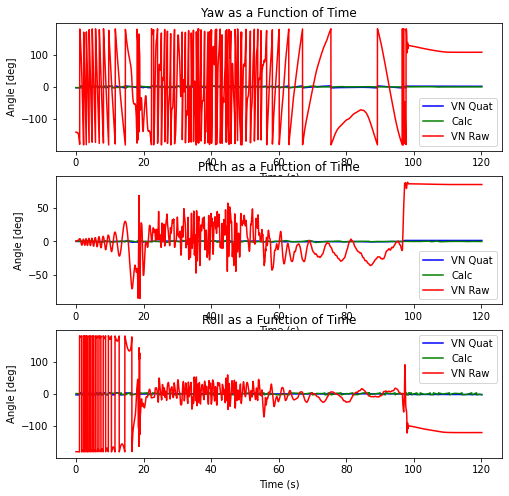

In [37]:
fig1 = plt.figure(1, figsize=(8,8))

ax1 = plt.subplot(311)
l1 = ax1.plot(tdata, vnyaw, color='blue', label='VN Quat')
l2 = ax1.plot(tdata, byaw, color='green', label='Calc')
l3 = ax1.plot(tdata, yaw, color='red', label='VN Raw')
ax1.set_title("Yaw as a Function of Time")

ax2 = plt.subplot(312)
l1 = ax2.plot(tdata, vnpitch, color='blue', label='VN Quat')
l2 = ax2.plot(tdata, bpitch, color='green', label='Calc')
l3 = ax2.plot(tdata, pitch, color='red', label='VN Raw')
ax2.set_title("Pitch as a Function of Time")

ax3 = plt.subplot(313)
l1 = ax3.plot(tdata, vnroll, color='blue', label='VN Quat')
l2 = ax3.plot(tdata, broll, color='green', label='Calc')
l3 = ax3.plot(tdata, roll, color='red', label='VN Raw')
ax3.set_title("Roll as a Function of Time")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel("Angle [deg]")
    ax.legend()

print("Comparing each angular component")
plt.show()

Comparing each set


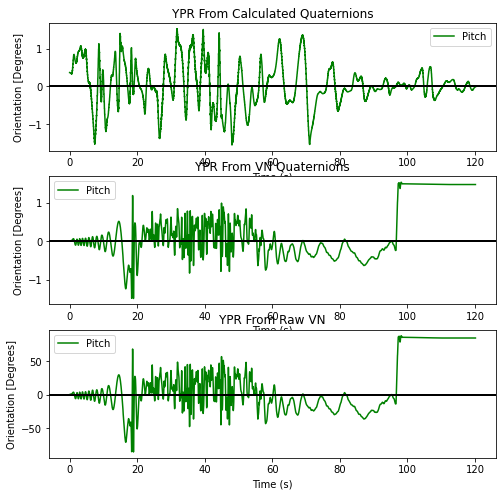

In [38]:
fig1 = plt.figure(1, figsize=(8,8))
ax1 = plt.subplot(311)
#l2 = ax1.plot(tdata, byaw, color='red', label='Yaw')
l3 = ax1.plot(tdata, bpitch, color='green', label='Pitch')
#l4 = ax1.plot(tdata, broll, color='purple', label='Roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax1.set_title("YPR From Calculated Quaternions")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel("Orientation [Degrees]")
ax1.legend()

ax1 = plt.subplot(312)
#l2 = ax1.plot(tdata, vnyaw, color='red', label='Yaw')
l3 = ax1.plot(tdata, vnpitch, color='green', label='Pitch')
#l4 = ax1.plot(tdata, vnroll, color='purple', label='Roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax1.set_title("YPR From VN Quaternions")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel("Orientation [Degrees]")
ax1.legend()

ax1 = plt.subplot(313)
#l2 = ax1.plot(tdata, yaw, color='red', label='Yaw')
l3 = ax1.plot(tdata, pitch, color='green', label='Pitch')
#l4 = ax1.plot(tdata, roll, color='purple', label='Roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax1.set_title("YPR From Raw VN")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel("Orientation [Degrees]")
ax1.legend()

print("Comparing each set")
plt.show()

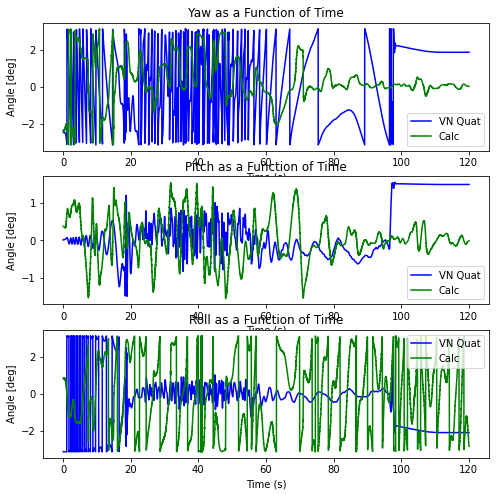

In [39]:
fig1 = plt.figure(1, figsize=(8,8))

ax1 = plt.subplot(311)
l1 = ax1.plot(tdata, vnyaw, color='blue', label='VN Quat')
l2 = ax1.plot(tdata, byaw, color='green', label='Calc')
ax1.set_title("Yaw as a Function of Time")

ax2 = plt.subplot(312)
l1 = ax2.plot(tdata, vnpitch, color='blue', label='VN Quat')
l2 = ax2.plot(tdata, bpitch, color='green', label='Calc')
ax2.set_title("Pitch as a Function of Time")

ax3 = plt.subplot(313)
l1 = ax3.plot(tdata, vnroll, color='blue', label='VN Quat')
l2 = ax3.plot(tdata, broll, color='green', label='Calc')
ax3.set_title("Roll as a Function of Time")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel("Angle [deg]")
    ax.legend()

plt.show()

In [40]:
print("Notice that the scales are wildly different, but within the YPR, the scale is correct.")
print()
print(f"Scale comparison: Raw {max(yaw):.4} VS Calc {max(byaw):.4}: RATIO: {max(yaw)/max(byaw):.4}")
print(f"Scale comparison: Raw {max(pitch):.4} VS Calc {max(bpitch):.4}: RATIO: {max(yaw)/max(byaw):.4}")
print(f"Scale comparison: Raw {max(roll):.4} VS Calc {max(broll):.4}: RATIO: {max(yaw)/max(byaw):.4}")

Notice that the scales are wildly different, but within the YPR, the scale is correct.

Scale comparison: Raw 179.9 VS Calc 3.138: RATIO: 57.34
Scale comparison: Raw 88.46 VS Calc 1.525: RATIO: 57.34
Scale comparison: Raw 179.9 VS Calc 3.136: RATIO: 57.34


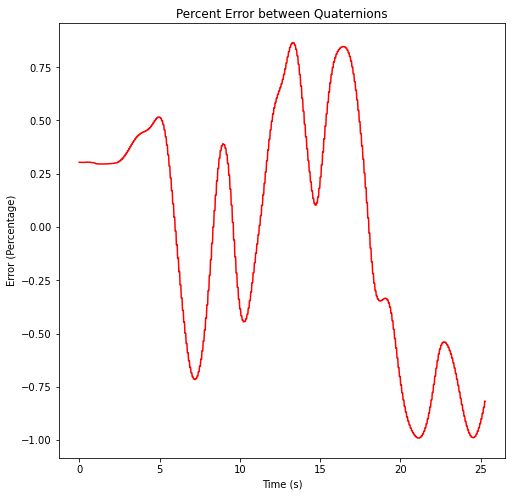

In [41]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata[0:1000], qx[0:1000], color='red', label='x')
#l2 = ax.plot(tdata, qye, color='blue', label='y')
#l3 = ax.plot(tdata, qze, color='green', label='z')
#l4 = ax.plot(tdata, qwe, color='purple', label='w')
#l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Percent Error between Quaternions")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Error (Percentage)")
#ax.legend()
plt.show()

In [42]:
# POSITION AND VELOCITY INTEGRATION
# idv is dv in the inerital frame (NED)
# Put the body frame dv into the inertial frame

def make_rot_matrix(yaw, pitch, roll):
    Ry = np.array([[cos(pi/180*yaw), -sin(pi/180*yaw), 0],
                   [sin(pi/180*yaw), cos(pi/180*yaw), 0],
                   [0, 0, 1]])
    Rp = np.array([[cos(pi/180*pitch), 0, sin(pi/180*pitch)],
                   [0, 1, 0],
                   [-sin(pi/180*pitch), 0, cos(pi/180*pitch)]])
    Rr = np.array([[1, 0, 0],
                   [0, cos(pi/180*roll), -sin(pi/180*roll)],
                   [0, sin(pi/180*roll), cos(pi/180*roll)]]) 
    return np.matmul( np.matmul(Ry, Rp), Rr )


R = make_rot_matrix(byaw[0], bpitch[0], broll[0])
bdv = dVel[:,0]
idv = R * bdv

## Position Determination from YPR (DV method)
> Go to the other NB, I don't remember where I was trying to go with this stuff in this NB

In [27]:
# Idk why this is here
# 57.37 scales these values to the collected quaternion
# Obviously, rerunning this cell will continue to scale the values, way too high

'''
byaw *= 57.37
bpitch *= 57.37
broll *= 57.37

vecfunc = np.vectorize(convert_YPR_fixed_frame)
result=vecfunc(1,2,3)
print(result.shape)
print("---------------------")
result = convert_YPR_fixed_frame(1,2,3)
print(result.shape)
print("---------------------")
result=vecfunc(byaw,bpitch,broll)
print(result.shape)
'''

1

1